<a href="#Overview"></a>
# Overview
* <a href="#cc6e70f3-136c-4577-9ff1-e06161587837">Week 4: Work with confocal image data</a>
  * <a href="#7a94433b-d143-4e31-9225-81f3b4cde86b">Introduction</a>
  * <a href="#f48a28f7-ae73-4f51-9946-07b3e567bf73">The data format</a>
  * <a href="#9a053838-dcd0-4c2d-8f6f-aa989fb5198a">The data</a>
  * <a href="#6cf39d01-d650-4b2c-8e7d-81a28a1d89d6">The problem</a>
    * <a href="#94c9fe20-f0f7-4a03-906c-d52eae4c7034">Function list</a>
  * <a href="#a15b790a-7efe-410a-8fb3-054af2cbd97f">Loading the data</a>
  * <a href="#0c50bb2d-7532-4547-a2e0-a1996fed3cc2">Indexing Numpy arrays and plotting them</a>
    * <a href="#4f3197a6-4574-4f57-b0d4-bb53237b6982">Review - extracting a range from a numpy array</a>
    * <a href="#975bb79d-5632-4a7e-8819-c463580fc65b">Review - mean along one axis</a>
    * <a href="#d1a91b7d-5332-44dd-96f8-f7292f16f56b">Review - call mean as a method</a>
    * <a href="#b0b9debd-289f-4a58-9c63-3539143cb1aa">Exercise 1: calculate the maximum projection</a>
    * <a href="#3457f1e6-9703-4da2-9121-d173befb432c">Exercise 2: Cropping the dataset and plotting it</a>
    * <a href="#d174145a-03fb-4aac-b084-63bcffe17eaf">Exercise 3: Using the documentation to figure out how to modify plotting behavior</a>
  * <a href="#e6d523c2-d897-4418-9bf9-419b7dcac1f9">Using saved statistics to analyze the image</a>
    * <a href="#46931302-f562-4638-87b1-3210f76b4266">Exercise 4: overlaying a scatterplot on the image</a>
    * <a href="#68b849d5-4559-4b58-b7b3-1bdcd2f8e739">Exercise 5: extract a fixed volume relative to puncta coordinates</a>
    * <a href="#8c457068-50ef-43d4-a871-8fa964fc1d11">Exercise 6: repeat for the receptor signal</a>
  * <a href="#e71d71c9-2531-4a56-b4da-157b2b21ecb4">Quantifying the receptor signal</a>
    * <a href="#09fc82c3-5f82-484b-9376-5f97c4d8fc4f">Exercise 7: Calculate mean receptor signal near each puncta</a>
    * <a href="#4242e30d-b3dc-4104-8130-ddcbb4a82103">Exercise 8: plot histogram of receptor signal and count number of functional synapses</a>
  * <a href="#d0e19df4-e714-449a-9aaf-366dc2200162">Bonus - Creating a composite image</a>

<a id="cc6e70f3-136c-4577-9ff1-e06161587837"></a>
# Week 4: Work with confocal image data
<a href="#Overview">Return to overview</a>


<a id="7a94433b-d143-4e31-9225-81f3b4cde86b"></a>
## Introduction
<a href="#Overview">Return to overview</a>

Today, we'll work with three-dimensional numpy arrays. We'll also get into important ideas around working with data generated by third-party software and handling large datasets more generally. Unlike Pandas DataFrames, which are designed to work with tabular (two-dimensional) data, Numpy arrays are designed to work with multidimensional data. This makes them especially well suited for confocal datasets, which often contain three-dimensional image data.

Thanks to Brad Buran and the original Python Neuroscience Bootcamp crew for putting together the original version of this notebook!

<a id="f48a28f7-ae73-4f51-9946-07b3e567bf73"></a>
## The data format
<a href="#Overview">Return to overview</a>

Imaris is a third-party program that facilitates analysis of data acquired from a confocal and saves it in an open-sorce format based on HDF5. **HDF5 stands for hierarchial data format version 5.** A number of programming languages have packages for reading this file format. There are two main packages for Python, `h5py` and `pytables`. We will use `pytables` today.

You can get some more background on pytables <a href="https://www.pytables.org/usersguide/tutorials.html">here</a>. Note that `pytables` is designed to work closely with pandas, but `h5py` is more widely used in the community. They are quite similar conceptually.

<a id="9a053838-dcd0-4c2d-8f6f-aa989fb5198a"></a>
## The data
<a href="#Overview">Return to overview</a>

Up to 25 auditory nerve fibers synapse onto individual inner hair cells in
normal-hearing individuals. However, these synapses can be permanently lost due
to aging, exposure to noise or ototoxic drugs.  In experiments that study
hearing loss, we need a way of quantifying the number of synapses per inner
hair cell.

One approach is to dissect the cochlea out of the experimental animals and use
whole-mount immunohistochemistry to label the tissue with antibodies for
pre-synaptic ribbons (CtBP2), post-synaptic receptors (GluR2) and cytoskeleton
(Myosin VIIa). In a second step, each antibody is tagged with a fluorescent dye
that can be illuminated using a laser (much like how a black light can cause
certain materials to glow).

The distribution of these fluorescent dyes (which map to the underlying
distribution of the proteins of interest) can be captured by taking a series of
two-dimensional images at various depths in the tissue.  These images are then
"stacked" to create a three-dimensional image known as a Z-stack (since the
third dimension is commonly referred to as the Z-axis).

For this exercise, the dataset has been trimmed down to a small subset showing
only two inner hair cells (the full dataset is 0.5 GB in size) with CtBP2 (fig.
1a) and GluR2 (fig. 1b).

**For simplicity, we will refer to the CtBP2 label as "ribbon" and the GluR2 label as "receptor".**

<table>
	<body>
		<tr>
			<td>1A. CtBP2 (pre-synaptic ribbon)</td>
			<td>1B. GluR2 (post-synaptic glutamate receptor)</td>
		</tr>
		<tr>
			<td><img src="data/CtBP2.png" /></td>
			<td><img src="data/GluR2.png" /></td>
		</tr>
	</body>
</table>

During confocal acquisition the signal intensity of each label is acquired as a separate **channel**. For each label, we have a separate set of three-dimensional image data representing the signal intensity for that label.

<a id="6cf39d01-d650-4b2c-8e7d-81a28a1d89d6"></a>
## The problem
<a href="#Overview">Return to overview</a>

This dataset was analyzed using Imaris to identify all ribbon puncta (white dots
in fig. 2a). If you look closely at the composite (fig. 2b), you'll see that
not all puncta have a glutamate receptor patch next to them (fig. 2b). 

<table>
	<body>
		<tr>
			<td>A. CtBP2 puncta</td>
			<td>B. CtBP2 puncta overlaid on GluR2</td>
		</tr>
		<tr>
			<td><img src="data/CtBP2+points.png" /></td>
			<td><img src="data/CtBP2+GluR2+points.png" /></td>
		</tr>
	</body>
</table>

A functional inner hair cell synapse requires both a pre-synaptic ribbon and a
post-synaptic glutamate receptor. The next step in our analysis is to determine
whether each ribbon puncta is near a receptor.

One approach is to extract a fixed volume around each ribbon puncta (e.g., a 1um
cube) and quantify the amount of receptor label in that volume. Let's get started!

<a id="94c9fe20-f0f7-4a03-906c-d52eae4c7034"></a>
### Function list
<a href="#Overview">Return to overview</a>

`pytables` (library `tables`) functions
* `open_file`
* `get_node`
* `node.read`
* `print`

Assorted others
* `plt.imshow`
* `plt.hist`
* `pd.describe`
* `imaris` - custom library functions


<a id="a15b790a-7efe-410a-8fb3-054af2cbd97f"></a>
## Loading the data
<a href="#Overview">Return to overview</a>

First, let's import a few modules we'll need. Remember that a Python module is basically a Python file (or collection of files) that contain useful functions that you can use in your code. 

Most of them are common third-party modules; for today, however, we have written a helper module (`imaris`) to extract some of the statistics (calculated by Imaris). You loaded these statistics from a comma-separated-values (CSV) file previously. We are now going to load it directly from the HDF5 file itself.

In [1]:
# Popular third-party libraries
import matplotlib.pyplot as plt
import tables as tb
import numpy as np
import pandas as pd

# Custom module written for this exercise
import imaris

# This is a special "magic" command that can be used in Jupyter Notebooks.
# It ensures that Matplotlib shows the plot below each cell (you won't see
# a plot otherwise).
%matplotlib inline

# Set the default precision for printing data in Numpy arrays. This is handy for 
# preventing confusing XXe-N notation.
np.set_printoptions(precision=4)

Now, let's open the file using the `pytables` library. Even though the library
is called `pytables`, it installs itself in Python as `tables` and we imported
it as `tb`.

Here, `tb` is a module and `open_file` is a function defined in the module. The
`open_file` function takes the path to the file and returns a PyTables `File`
object.

You've already worked extensively with objects before. A `DataFrame` is an
object. Even a simple integer is an object! Objects can be thought of as a
collection of data (i.e., attributes on the object) and functions (i.e.,
methods on the object) that operate on this data.

Here, `fh` is a `File` object that knows where the data is stored on disk, but
it hasn't actually loaded the data itself. That's a good thing. HDF5 files can
be many gigabytes in size (most computers only have a few gigabytes of memory).
However, it has methods that help you load the data you need.

In [2]:
fh = tb.open_file('data/confocal dataset.ims')

Now what? If you've never worked with a particular type of object before, you
can explore it a number of ways. We've already discussed two ways you can
explore them. What are they?

Another way is to just type `print(fh)`. What actually gets printed depends on
how the developers of the library implement it for their particular object.
Sometimes you don't get anything useful. Fortunately, the `PyTables` developers
decided to produce useful output when you call the `print` function on a `File`
object.

Go ahead, try it.

In [3]:
print(fh)

data/confocal dataset.ims (File) ''
Last modif.: '2024-01-06T21:34:12+00:00'
Object Tree: 
/ (RootGroup) ''
/DataSet (Group) ''
/DataSetInfo (Group) ''
/DataSetTimes (Group) ''
/DataSetTimes/Time (Table(1,)) ''
/DataSetTimes/TimeBegin (Table(1,)) ''
/Scene (Group) ''
/Scene/Data (VLArray(1,)) ''
/Scene8 (Group) ''
/Scene8/Data (VLArray(1,)) ''
/Thumbnail (Group) ''
/Thumbnail/Data (Array(194, 776)) ''
/Scene8/Content (Group) ''
/Scene8/Content/Points0 (Group) ''
/Scene8/Content/Points0/Category (Table(2,)) ''
/Scene8/Content/Points0/Factor (Table(6,)) ''
/Scene8/Content/Points0/FactorList (Table(6,)) ''
/Scene8/Content/Points0/LabelGroupNames (Table(0,)) ''
/Scene8/Content/Points0/LabelSetLabelIDs (Table(0,)) ''
/Scene8/Content/Points0/LabelSetObjectIDs (Table(0,)) ''
/Scene8/Content/Points0/LabelSets (Table(0,)) ''
/Scene8/Content/Points0/LabelValues (Table(0,)) ''
/Scene8/Content/Points0/MainTrackSegmentTable (Table(1,)) ''
/Scene8/Content/Points0/Spot (Table(47,)) ''
/Scene8/Content

This is a lot of information. As you can see, it nicely illustrates the
structure of an HDF5 file. Recall that HDF5 is short for "hierarchial
data format"? You can see that the data in the file is organized into
what looks like a file-path like structure (e.g., `/Scene8/Content/Points0`).
Much like your computer filesystem, the data is organized into "folders" (known
as "groups" in HDF5 parlance) and "files" (known as "nodes" in HDF5 parlance).
It's almost like a filesystem within a file.

We're interested in finding the actual three-dimensional image data. Let's look
through the information shown above. Does anything jump out as a clue as to where the data might be stored in the file?

In confocal imaging, each label is acquired using a separate wavelength channel. At the
bottom of the list we see several rows that mention `Channel 0`, `Channel 1`
and `Channel 2`. This is most likely the data we need.

However, the channels appear several times (under `ResolutionLevel 0` and
`ResolutionLevel 1`). Which one do we want? Our intuition as a programmer tells
us that Imaris likely generates the dataset at multiple resolutions and uses
the appropriate resolution based on your zoom level. For quantitative analysis,
we probably want the highest resolution level. 

Take another look at the list. You'll notice that at the end of each line
there's an indicator in parenthesis (`Group`, `Array`, `CArray`).  different
types of nodes in the HDF5 file. 

Now, let's look at the `Channel 0/Data` line for each resolution level. There's
some information about the size of the array. This tells us that
`ResolutionLevel 0` contains the highest resolution data and `ResolutionLevel 1` 
contains the lowest resolution data. Otherwise, they should be identical.

<a id="0c50bb2d-7532-4547-a2e0-a1996fed3cc2"></a>
## Indexing Numpy arrays and plotting them
<a href="#Overview">Return to overview</a>

Let's take a look at `Channel 0` so we can understand how to work with
the data. Based on the acquisition settings, channel 0 is the ribbon label and channel 1 is the receptor label. Let's start with the ribbon label.

The file object has a method, `get_node` that returns a node object. This node object provides a method, `read`, that loads the data from disk and returns it as a Numpy array object.

The array object has a `shape` attribute that tells you the size of the array.

In [4]:
node = fh.get_node('/DataSet/ResolutionLevel 0/TimePoint 0/Channel 0/Data')
data_ribbon = node.read()
print(data_ribbon.shape)

(144, 256, 256)


Note that there are three numbers. The reflects the fact that we're working with three-dimensional image data. Since we're working with image data, each element in the array represents a voxel (i.e., a 3D pixel). Here's a way to visualize a 3D array:

<img src="data/array_colour_slices.png" />

**Helpful note:** In the Imaris data, the first dimension is the Z-axis, second dimension the Y-axis and third (last) dimension the X-axis. The ordering of the dimensions is how Imaris saves the data, but another program may save the Z-axis as the last dimension. You can usually figure it out, and usually this information can be found somewhere in the documentation.

Say you want to pull out the pixel located at XYZ coordinates (60, 20, 50). Remember how to do this?

In [6]:
# %load "answers/answer_001.txt"
#Answer
data_ribbon[50, 20, 60]

19

<a id="4f3197a6-4574-4f57-b0d4-bb53237b6982"></a>
### Review - extracting a range from a numpy array
<a href="#Overview">Return to overview</a>

If you want to extract a *range* of values, you can use the slice syntax. How do you extract the first two elements from a list? Do it for `x_list`.

In [7]:
x_list = ['a','b','c','d']

In [12]:
# %load "answers/answer_002.txt"
#Answer
x_list[:2]

['a', 'b']

Let's pull out three elements from each dimension (this gives us a total of 3 x 3 x 3 = 27 values). As shown in the output below the cell, it looks like a set of 3 x 3 arrays that have been stacked 3-high.

In [13]:
data_ribbon.shape

(144, 256, 256)

In [16]:
data_ribbon[50:53, 20:23, 60:63]

array([[[19, 17, 15],
        [18, 16, 12],
        [18, 16, 11]],

       [[17, 13, 13],
        [18, 13, 10],
        [22, 16,  9]],

       [[13, 10, 12],
        [17, 12,  9],
        [22, 15,  7]]], dtype=uint8)

There are ways to visualize 3D data in Python. However, these approaches are
not readily available out of the box for Jupyter notebooks. Let's focus on simple 2D plotting
instead. A common way of presenting confocal image stacks is to take the
maximum projection along an an axis (i.e., dimension). Let's take the maximum
projection along the first axis (i.e., Z-axis).

In week 2, we talked about how you can calculate statistics along an axis of a Numpy array. Let's refresh our memory.

In [17]:
data_2D = np.random.rand(3, 2)
print('Full dataset')
print(data_2D)

Full dataset
[[0.178  0.4042]
 [0.762  0.3764]
 [0.8185 0.263 ]]


By convention, a two-dimensional array has two axes: the first running vertically downwards across rows (axis 0) and the second running horizontally across columns (axis 1).


<a id="975bb79d-5632-4a7e-8819-c463580fc65b"></a>
### Review - mean along one axis
<a href="#Overview">Return to overview</a>

We can pass an axis argument to the Numpy statistics functions (e.g., `mean`, `std`, `mean`) indicating which axis to operate across. If we take the mean of axis 0 (e.g., `np.mean(data_2D, axis=0)`) what is the shape of the result? What about when taking the mean of axis 1?

In [19]:
# %load "answers/answer_003.txt"
#Answer
print('\nMean across axis 0')
print(np.mean(data_2D, axis=0))

print('\nMean across axis 1')
print(np.mean(data_2D, axis=1))


Mean across axis 0
[0.5862 0.3479]

Mean across axis 1
[0.2911 0.5692 0.5408]


<a id="d1a91b7d-5332-44dd-96f8-f7292f16f56b"></a>
### Review - call mean as a method
<a href="#Overview">Return to overview</a>

In addition to using the `mean` function available through the Numpy module (called `np` in this notebook), there is also a `mean` method available through the array object that performs the same operation. Go ahead, try it!

In [21]:
# %load "answers/answer_004.txt"
#Answer
print(data_2D.mean(axis=0))

[0.5862 0.3479]


Let's take a look at a very simple 3D array with shape 4 x 3 x 2. When printing a 3D array, Numpy prints out each 2D section separately.

In [22]:
data_3D = np.random.rand(4, 3, 2)

print('Full dataset')
print(data_3D)

Full dataset
[[[0.8821 0.3949]
  [0.1676 0.8354]
  [0.6363 0.6561]]

 [[0.4512 0.2877]
  [0.1621 0.9882]
  [0.7124 0.2357]]

 [[0.5085 0.0715]
  [0.2334 0.2017]
  [0.0601 0.9242]]

 [[0.5179 0.6607]
  [0.8956 0.5521]
  [0.7934 0.645 ]]]


What will the shape of the resulting array be if you take the mean of the first axis? Second axis? Third axis?

In [24]:
print('\nMean across axis 0')
print(np.mean(data_3D, axis=0))
print(np.mean(data_3D, axis=0).shape)

print('\nMean across axis 1')
print(np.mean(data_3D, axis=1))
print(np.mean(data_3D, axis=1).shape)

print('\nMean across axis 2')
print(np.mean(data_3D, axis=2))
print(np.mean(data_3D, axis=2).shape)



Mean across axis 0
[[0.5899 0.3537]
 [0.3647 0.6444]
 [0.5506 0.6152]]
(3, 2)

Mean across axis 1
[[0.562  0.6288]
 [0.4419 0.5039]
 [0.2673 0.3991]
 [0.7356 0.6193]]
(4, 2)

Mean across axis 2
[[0.6385 0.5015 0.6462]
 [0.3695 0.5752 0.4741]
 [0.29   0.2175 0.4921]
 [0.5893 0.7238 0.7192]]
(4, 3)


<a id="b0b9debd-289f-4a58-9c63-3539143cb1aa"></a>
### Exercise 1: calculate the maximum projection
<a href="#Overview">Return to overview</a>

Now, calculate the maximum projection, along the Z-axis, of the confocal image. The maximum projection is the max value along that axis. You can either use the function, `np.max`, or the object method `data_ribbon.max`.

Save it to a variable called `projection`.

In [26]:
# %load "answers/answer_005.txt"
#Answer
projection = data_ribbon.max(axis=0)

Note the shape of the projection. The Z-axis has been dropped, leaving us with a two-dimensional array that we can plot as an image.

In [27]:
print('Shape of full dataset', data_ribbon.shape)
print('Shape of projection', projection.shape)

Shape of full dataset (144, 256, 256)
Shape of projection (256, 256)


Now, let's plot this 2D projection. The `origin='lower'` argument to `plt.imshow` indicates that the data at `projection[0, 0]` should appear at the lower left corner of the axes instead of the default location (the upper left).

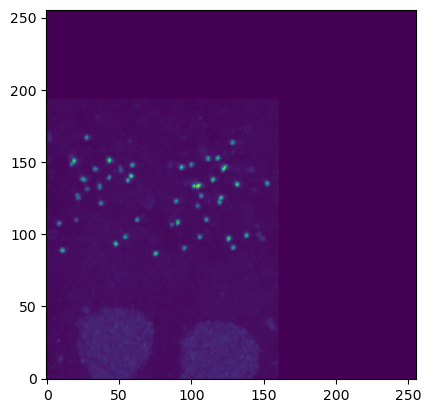

In [30]:
plt.imshow(projection, origin='lower')

<a id="3457f1e6-9703-4da2-9121-d173befb432c"></a>
### Exercise 2: Cropping the dataset and plotting it
<a href="#Overview">Return to overview</a>

It looks like the image has been "padded" with empty data by Imaris, making it a bit ugly to look at. Let's crop out that extra data. To do this, we need to find out what the actual image extents are in pixels. There is a way to do this by looking at the HDF5 file, but this is outside the scope of the exercise. For now, we provide the numbers for you.

In [31]:
x_pixels = 161
y_pixels = 194
z_pixels = 135

Use Numpy indexing to crop out the valid `z_pixels` x `y_pixels` x `x_pixels` array. Test that your answer makes sense by plotting the maximum projection of that new array.

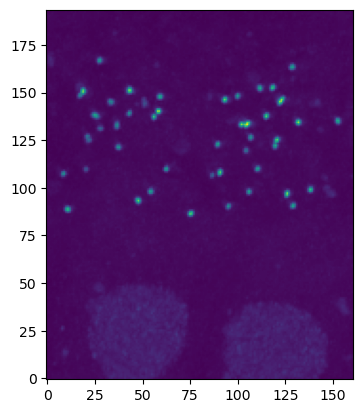

In [35]:
# %load "answers/answer_006.txt"
#Answer
cropped_ribbon = data_ribbon[:z_pixels, :y_pixels, :x_pixels]
projection = cropped_ribbon.max(axis=0)
plt.imshow(projection, origin='lower')

In [33]:
data_ribbon_without_padding = data_ribbon[:z_pixels, :y_pixels, :x_pixels]
projection = data_ribbon_without_padding.max(axis=0)
projection.shape

(194, 161)

<a id="d174145a-03fb-4aac-b084-63bcffe17eaf"></a>
### Exercise 3: Using the documentation to figure out how to modify plotting behavior
<a href="#Overview">Return to overview</a>

The units on the X and Y-axes are in pixels. Let's convert them to actual image dimensions (in microns). First, you need to know the actual dimensions (again this can be done by looking at the HDF5 file, but we provide the numbers for you). These are the the dimensions of the cropped dataset.

In [38]:
x_um = 22.7418
y_um = 27.442
z_um = 21.526

Now, remember how to get help on a function? Take a look at the documentation for `plt.imshow`. Any clues as to what arguments can be used to get `imshow` to properly map each pixel to it's spatial location in microns? As a bonus, be sure to label the X and Y axes too! You can use the `xlabel` and `ylabel` functions available through the matplotlib.pyplot module (`plt` in this notebook).

In [41]:
xw_um = x_um
yw_um = y_um
print("x x y:", xw_um, "X", yw_um)
extent = [0, x_um, 0, y_um]

x x y: 22.7418 X 27.442


Text(0, 0.5, 'Position Y (μm)')

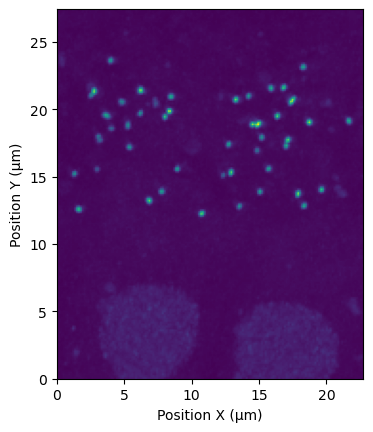

In [43]:
# %load "answers/answer_007.txt"
#Answer
extents = (0, x_um, 0, y_um)
plt.imshow(projection, origin='lower', extent=extents)
plt.xlabel('Position X (μm)')
plt.ylabel('Position Y (μm)')

<a id="e6d523c2-d897-4418-9bf9-419b7dcac1f9"></a>
## Using saved statistics to analyze the image
<a href="#Overview">Return to overview</a>

Now, we need to load the data about the ribbon puncta that were identified using Imaris. Specifically, we need to know the XYZ location of each puncta. A function from the `imaris` module called `load_node_stats` can be used to load this from the Imaris file. The function takes three arguments (the PyTables `File` object, the name of the label and the type of statistics to extract). 

In [44]:
stats_ribbon = imaris.load_node_stats(fh, 'CtBP2', 'point')

In [45]:
stats_ribbon.head()

name,X,Y,Z
id_object,,,
0,6.832067,13.227180,3.471509
1,1.618101,12.583703,6.194899
2,8.917457,15.587427,10.085184
3,10.723404,12.270201,3.841082
4,17.863073,13.743260,6.161555


Another useful pandas method is `describe`:

In [46]:
stats_ribbon.describe()

name,X,Y,Z
count,47.000000,47.000000,47.000000
mean,10.788394,17.904929,10.624672
std,5.906965,3.049134,3.756406
min,1.294627,12.270201,1.341601
25%,5.309280,15.444492,7.766121
50%,12.321580,18.584343,11.422837
75%,15.770262,20.518848,13.547657
max,21.621861,23.639858,16.378813


<a id="46931302-f562-4638-87b1-3210f76b4266"></a>
### Exercise 4: overlaying a scatterplot on the image
<a href="#Overview">Return to overview</a>

Our goal is to take the plot we created using `imshow` (with the axes showing the correct spatial location in microns) and overlay a scatterplot showing the location of each ribbon puncta identified by Imaris.

You've already learned how to inspect the contents of a dataframe. Take a look at the dataframe. What type of information does it have? What are the units (e.g., pixels or microns)?

Once you have figured out how to obtain the X and Y coordinates for each puncta, you can plot them using `plt.plot(x_coordinates, y_coordinates, 'r+')` (the `'r+'` specifies a red cross marker). Do the coordinates align with the puncta observed in the image?

In [ ]:
%load "answers/answer_008.txt"

Text(0, 0.5, 'Position Y (μm)')

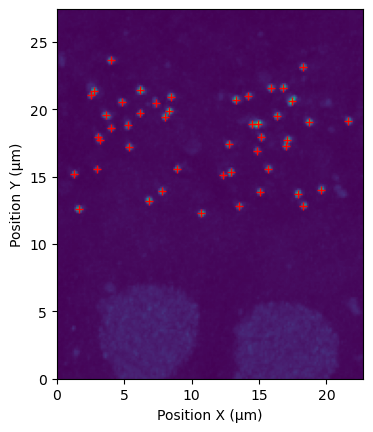

In [55]:
extents = (0, x_um, 0, y_um)

# ?
x_coordinates = stats_ribbon['X']
y_coordinates = stats_ribbon['Y']
plt.imshow(projection, origin='lower', extent=extents)

plt.plot(x_coordinates, y_coordinates, 'r+')

plt.xlabel('Position X (μm)')
plt.ylabel('Position Y (μm)')

We want to use this data to extract a 1μm x 1μm x 1μm cube centered around each puncta. To do this we need to convert from microns to pixels. Since we know the dimensions in pixels and microns, we can calculate the size of each pixel.

In [56]:
x_size = x_um/x_pixels
y_size = y_um/y_pixels
z_size = z_um/z_pixels

print('Pixel size (x-axis) {:.2f}'.format(x_size))
print('Pixel size (y-axis) {:.2f}'.format(y_size))
print('Pixel size (z-axis) {:.2f}'.format(z_size))

Pixel size (x-axis) 0.14
Pixel size (y-axis) 0.14
Pixel size (z-axis) 0.16


Each pixel along the X and Y axes are 0.14 microns and the Z axis is 0.16 microns. If we want to convert from microns to pixels, we can divide by the pixel size. This means that a 1μm x 1μm x 1μm cube is approximately 7 x 7 x 6 pixels in size (rounded to the nearest pixel). For simplicity, let's assume that the cube should be 7 x 7 x 7 pixels in size.


<a id="68b849d5-4559-4b58-b7b3-1bdcd2f8e739"></a>
### Exercise 5: extract a fixed volume relative to puncta coordinates
<a href="#Overview">Return to overview</a>

Now that you know how to convert from microns to pixels, let's pull out the first puncta in the dataframe and plot the maximum projection of the 1μm³ region centered around the puncta.

If you don't remember how to extract the first row of the dataframe, take a look at day 2.

First, one small caveat. When indexing Numpy arrays (and also Python lists), you must use integers. Since divison returns floating point values, you need to cast the result to an integer.

In [64]:
result = 32/4
result, type(result)

(8.0, float)

In [66]:
int(8.6)

8

In [60]:
int_result = int(round(result))
int_result,type(int_result)

(8, int)

Now, enter your solution below:
* Convert coordinates stored in first row of dataframe to pixels. Don't forget to cast to an integer!
* Extract cube from `data_ribbon`. Be sure to verify its size is 7 x 7 x 7.
* Compute maximum projection along z-axis and plot it.
* Ensure axes are labeled appropriately and reflect data coordinates, not pixel coordinates.

Text(0, 0.5, 'Position Y (μm)')

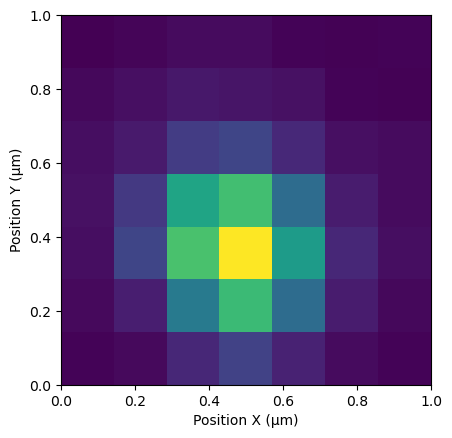

In [84]:
# %load "answers/answer_009.txt"
#Answer
point = stats_ribbon.loc[0]

x_px = int(round(point['X']/x_size))
y_px = int(round(point['Y']/y_size))
z_px = int(round(point['Z']/z_size))

subset_ribbon = data_ribbon[z_px-4:z_px+4, y_px-3:y_px+4, x_px-3:x_px+4]
projection_ribbon = subset_ribbon.max(axis=0)
plt.imshow(projection_ribbon, origin='lower', extent=(0, 1, 0, 1))
plt.xlabel('Position X (μm)')
plt.ylabel('Position Y (μm)')

(7, 7)


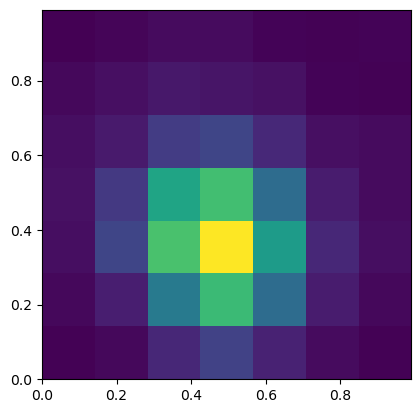

In [81]:
# get center coordinates from first row of dataframe:
x_ctr = stats_ribbon.loc[0,'X' ]
y_ctr = stats_ribbon.loc[0,'Y']
z_ctr = stats_ribbon.loc[0,'Z']

# convert to pixels and then integers:
x_ctr_pix = int(round(x_ctr / x_size))
y_ctr_pix = int(round(y_ctr / y_size))
z_ctr_pix = int(round(z_ctr / z_size))

# extract +/-3 pixels on all sides of center
cube = data_ribbon[ (z_ctr_pix-3):(z_ctr_pix+4), 
                    (y_ctr_pix-3):(y_ctr_pix+4), 
                    (x_ctr_pix-3):(x_ctr_pix+4)  ]
#print(cube.shape)

# collapse across z
puncta_projection = cube.max(axis=0)
print(puncta_projection.shape)

# plot!
plt.imshow( puncta_projection, origin='lower', extent=[0, 7*x_size, 0, 7*y_size] )

<a id="8c457068-50ef-43d4-a871-8fa964fc1d11"></a>
### Exercise 6: repeat for the receptor signal
<a href="#Overview">Return to overview</a>

Looks like we've adequately identified the cube we need. Now, let's load and crop the receptor data so we can plot the amount of receptor signal within this region as well.

In [85]:
node = fh.get_node('/DataSet/ResolutionLevel 0/TimePoint 0/Channel 1/Data')
data_receptor = node.read()
data_receptor = data_receptor[:z_pixels, :y_pixels, :x_pixels]

(194, 161, 3)


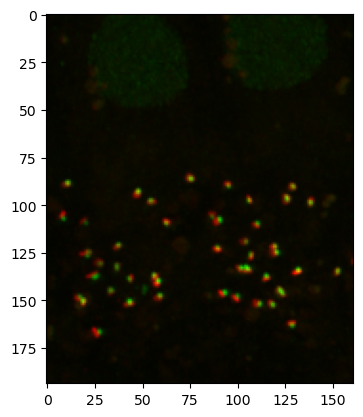

In [123]:
color = np.stack([data_receptor[:z_pixels, :y_pixels, :x_pixels].max(axis=0), 
                  data_ribbon[:z_pixels, :y_pixels, :x_pixels].max(axis=0),
                np.zeros_like(data_ribbon[0,:y_pixels,:x_pixels]),], axis=2)
plt.imshow(color)
print(color.shape)


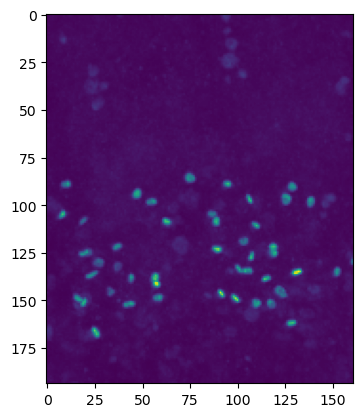

In [116]:
plt.imshow(data_receptor.max(axis=0), origin=0)

(7, 7)


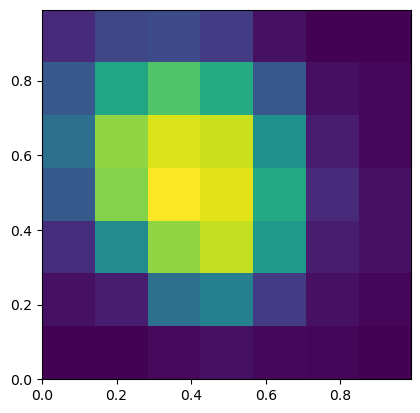

In [86]:
x_ctr = stats_ribbon.loc[0,'X' ]
y_ctr = stats_ribbon.loc[0,'Y']
z_ctr = stats_ribbon.loc[0,'Z']

# convert to pixels and then integers:
x_ctr_pix = int(round(x_ctr / x_size))
y_ctr_pix = int(round(y_ctr / y_size))
z_ctr_pix = int(round(z_ctr / z_size))

# extract +/-3 pixels on all sides of center
cube = data_receptor[ (z_ctr_pix-3):(z_ctr_pix+4), 
                    (y_ctr_pix-3):(y_ctr_pix+4), 
                    (x_ctr_pix-3):(x_ctr_pix+4)  ]
#print(cube.shape)

# collapse across z
puncta_projection = cube.max(axis=0)
print(puncta_projection.shape)

# plot!
plt.imshow( puncta_projection, origin='lower', extent=[0, 7*x_size, 0, 7*y_size] )

Text(0, 0.5, 'Position Y (μm)')

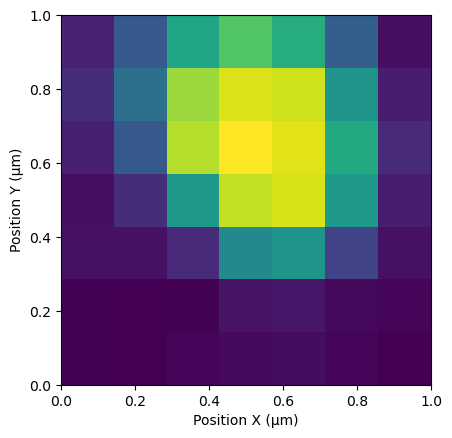

In [89]:
# %load "answers/answer_010.txt"
#Answer
subset_receptor = data_receptor[z_px-4:z_px+3, y_px-4:y_px+3, x_px-4:x_px+3]
projection_receptor = subset_receptor.max(axis=0)
plt.imshow(projection_receptor, origin='lower', extent=(0, 1, 0, 1))
plt.xlabel('Position X (μm)')
plt.ylabel('Position Y (μm)')

<a id="e71d71c9-2531-4a56-b4da-157b2b21ecb4"></a>
## Quantifying the receptor signal
<a href="#Overview">Return to overview</a>

Looks like there's some receptor signal next to the ribbon signal. Great! Now how do we quantify this? Maybe we can just take the average intensity within this subset? How do we do this?

In [91]:
mean_receptor_signal = subset_receptor.mean()
mean_receptor_signal

30.854227405247812

<a id="09fc82c3-5f82-484b-9376-5f97c4d8fc4f"></a>
### Exercise 7: Calculate mean receptor signal near each puncta
<a href="#Overview">Return to overview</a>

The next step is to loop through each row (i.e., puncta) in the dataframe and extract the mean receptor signal. This can then be saved back as a new column in the dataframe. We can loop through the rows using the `iterrows` method. On each cycle of the for loop, the `iterrows` method returns two values. The first value is the index of the row and the second value is the data in the row itself (stored in a dictionary-like format).

In [111]:
# %load "answers/answer_011.txt"
#Answer
signal = []
for _, puncta in stats_ribbon.iterrows():
    x_px = int(round(puncta['X']/x_size))
    y_px = int(round(puncta['Y']/y_size))
    z_px = int(round(puncta['Z']/z_size))
    subset_receptor = data_receptor[z_px-4:z_px+3, y_px-4:y_px+3, x_px-4:x_px+3]
    mean_receptor_signal = subset_receptor.mean()
    signal.append(mean_receptor_signal)
    
# Here, we can save the receptor signal back to the statistics dataframe as a new column
stats_ribbon['receptor'] = signal

In [113]:
stats_ribbon['receptor_signal']=0.0
for i,r in stats_ribbon.iterrows():
    # get center of punctUM
    x_ctr = r['X']
    y_ctr = r['Y']
    z_ctr = r['Z']
    
    # convert to pixels and then integers:
    x_ctr_pix = int(round(x_ctr / x_size))
    y_ctr_pix = int(round(y_ctr / y_size))
    z_ctr_pix = int(round(z_ctr / z_size))
    
    # extract voxel
    cube = data_receptor[(z_ctr_pix-4):(z_ctr_pix+3), 
                        (y_ctr_pix-4):(y_ctr_pix+3), 
                        (x_ctr_pix-4):(x_ctr_pix+3)  ]

    # compute mean & save result in correct row
    stats_ribbon.at[i,'receptor_signal'] = cube.mean()
stats_ribbon

name,X,Y,Z,receptor_signal
id_object,,,,
0,6.832067,13.227180,3.471509,30.854227
1,1.618101,12.583703,6.194899,25.559767
2,8.917457,15.587427,10.085184,31.279883
3,10.723404,12.270201,3.841082,33.390671
4,17.863073,13.743260,6.161555,39.556851
5,12.894011,15.322193,6.328891,24.988338
6,17.107695,17.729202,7.113818,27.244898
7,7.316211,20.474106,1.341601,2.434402
8,8.336864,19.866224,4.424723,29.367347


<a id="4242e30d-b3dc-4104-8130-ddcbb4a82103"></a>
### Exercise 8: plot histogram of receptor signal and count number of functional synapses
<a href="#Overview">Return to overview</a>

Now, let's plot a histogram of the receptor signal near each ribbon puncta. Look at the histogram. Are there any obvious outliers? Is there an obvious cutoff threshold? Based on this, how many functional synapses are there? 

If you're not sure how to plot a histogram. Take a look at the documentation for the `matplotlib.pyplot` module (referred to as `plt` in this notebook). Any particular functions jump out at you?

47 46


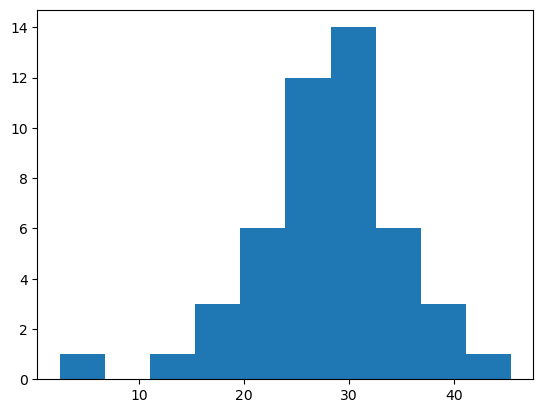

In [115]:
# %load "answers/answer_012.txt"
#Answer
plt.hist(stats_ribbon['receptor_signal'])
mask = stats_ribbon['receptor_signal'] > 10
print(len(stats_ribbon),len(stats_ribbon.loc[mask]))

<a id="d0e19df4-e714-449a-9aaf-366dc2200162"></a>
## Bonus - Creating a composite image
<a href="#Overview">Return to overview</a>

In the above images, `imshow` is using a color map in which purple reflects the regions with no signal and yellow reflects regions with the most signal. But, what if we'd like to merge the three channels into a single image where red is mapped to the ribbon and green to the receptor. How can we do this? Let's take another look at the documentation for `imshow`.

It looks `imshow` can take a 3D array where the last dimension maps to the three colors (i.e., `x[..., 0]` is red, `x[..., 1]` is green and `x[..., 2]` is blue). The documentation also warns that the values in the array must be in the range 0 ... 1 for this to work. Let's check that. 

In [ ]:
data_ribbon = data_ribbon[:z_pixels, :y_pixels, :z_pixels]
data_receptor = data_receptor[:z_pixels, :y_pixels, :z_pixels]

In [ ]:
data_ribbon.max()

Uh oh. We need to fix that. The simplest way to coerce data to the range 0 ... 1 is to divide by the maximum value. Let's do this and check that we did OK.

In [ ]:
norm_data_ribbon = data_ribbon/np.max(data_ribbon)
norm_data_receptor = data_receptor/np.max(data_receptor)

In [ ]:
norm_data_ribbon.max()

Great. Now we need to make the 2D image for each color and then merge them into a 3D array. A list of 2D images can be stacked into a 3D array using Numpy's `dstack` function. We need to make a blank image for the blue color. The quickest way to do this is to use the `zeros_like` function from Numpy which will create an array of the same shape, but filled with zeros.

In [ ]:
projection_ribbon = norm_data_ribbon.max(axis=0)
projection_receptor = norm_data_receptor.max(axis=0)
projection_blank = np.zeros_like(projection_ribbon)

data = [projection_ribbon, projection_receptor, projection_blank]
projection = np.dstack(data)

plt.imshow(projection)